In [112]:
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib qt

import numpy as np
from numpy import *
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit

import os
import scipy.io as sio

# PSD model: 1/f + 1/f^2 + white noise
def psd_full(f, A1, A2, C):
    return A1 / f + A2 / f**2 + C

# Fitting function
def get_full_fit(x_data, y_data):
    valid = (x_data > 0) & (y_data > 0) & np.isfinite(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    params, pcov = curve_fit(psd_full, x_clean, y_clean, maxfev=10000)
    A1, A2, C = params
    a1_err = np.sqrt(pcov[0, 0])
    return A1, A2, C, x_clean, y_clean, a1_err

In [113]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9'

folders = os.listdir(initial_folder)
for i in range(len(folders)):
    if ".fig" in folders[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', folders[i])

[0] -----------> 1st_tone
[1] -----------> Alan_var
[2] -----------> fast_saturation
[3] -----------> Gain_sweep_1000mK2025-07-17-22-37-20.mat
[4] -----------> Gain_sweep_10mK_power_freq2025-07-21-19-09-34.mat
[5] -----------> Gain_sweep_10mK_power_freq_1.382025-07-22-02-40-22.mat
[6] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-30-24.mat
[7] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-38-47.mat
[8] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-40-36.mat
[9] -----------> Gain_sweep_12mK2025-05-29-12-17-35.mat
[10] -----------> Gain_sweep_12mK2025-05-29-13-27-37.mat
[11] -----------> Gain_sweep_12mK2025-06-03-10-58-46.mat
[12] -----------> Gain_sweep_12mK2025-06-03-18-18-22.mat
[13] -----------> Gain_sweep_12mK_test_save2025-06-05-17-57-06.mat
[14] -----------> Gain_sweep_500mK2025-07-08-15-36-23.mat
[15] -----------> Gain_sweep_700mK2025-07-12-17-11-02.mat
[16] -----------> Gain_sweep_dense_lower_gain_500mK2025-07-04-19-17-46.mat
[17] ---------

In [114]:
file = folders[45]
mat = sio.loadmat(initial_folder+"\\"+file)
print(mat.keys(), '\n')

data_gain = mat['data_gain']
print(data_gain.shape)
volts = mat['volts'][0]
print('DC:', volts.shape)
pump_freqs = mat['pump_freqs'][0]
print('pf:', pump_freqs.shape)
pump_powers = mat['pump_powers'][0]
print('pp', pump_powers.shape)
fft_freq = mat['fft_freq'][0]
print('fft_freq:', fft_freq.shape)


data_mag = mat['data_mag'] # on/off
print(data_mag.shape)
data_pha = mat['data_pha'] # on/off
print(data_pha.shape)


dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq']) 

(101, 1, 1)
DC: (101,)
pf: (1,)
pp (1,)
fft_freq: (101,)
(101, 1, 1, 2, 101)
(101, 1, 1, 2, 101)


In [115]:
data_pha_ref = data_pha[:,0,0,1]/100/10*2
data_pha_mea = data_pha[:,0,0,0]/100/10*2

data_mag_ref = data_mag[:,0,0,1]/100/10*2
data_mag_mea = data_mag[:,0,0,0]/100/10*2

data_mag_mea.shape

(101, 101)

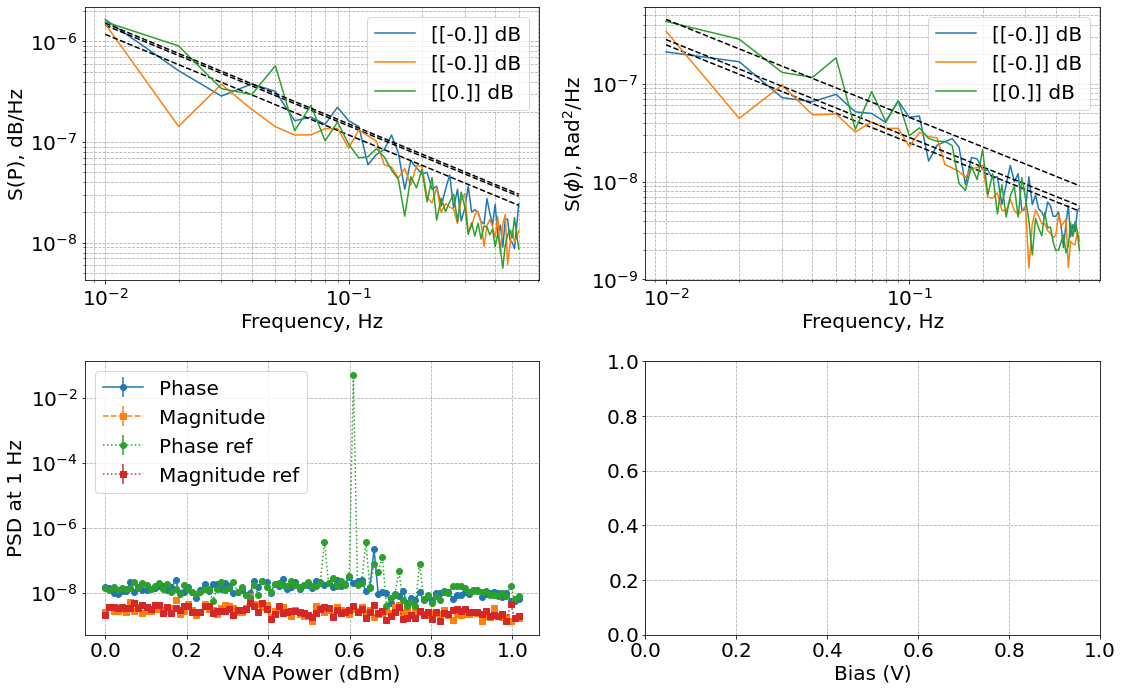

In [128]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter

# 1/f PSD model
def psd_full(f, A1):
    return A1 / f

# Fit function
def get_full_fit(x_data, y_data):
    valid = (x_data > 0) & (y_data > 0) & np.isfinite(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    params, pcov = curve_fit(psd_full, x_clean, y_clean, maxfev=10000)
    A1 = params[0]
    a1_err = np.sqrt(pcov[0, 0])
    return A1, x_clean, y_clean, a1_err

# Font
matplotlib.rc('font', size=20)

# Plot setup
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for a in ax.flat:
    a.grid(True, which="both", ls="--", alpha=1)
    a.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    a.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Storage arrays
a_pha, a_mag, a_pha_err, a_mag_err = [], [], [], []
a_pha_ref, a_mag_ref, a_pha_err_ref, a_mag_err_ref = [], [], [], []

# Example index set
idx_set = [0, 10, 20]

# Loop over voltages
for i in range(len(volts)):
    try:
        # Fit main phase
        A1, xf, yf, err = get_full_fit(fft_freq[-len(fft_freq)//2:], data_pha_mea[i][-len(fft_freq)//2:])
        if i in idx_set:
            ax[0,0].plot(xf, yf, label=f'{np.round(data_gain[i], 1)} dB')
            ax[0,0].plot(xf, psd_full(xf, A1), 'k--')
        a_pha.append(psd_full(1, A1))
        a_pha_err.append(err)
    except Exception as e:
        print(f"Phase fit failed at i={i}: {e}")
        
    try:
        # Fit main magnitude
        A1, xf, yf, err = get_full_fit(fft_freq[-len(fft_freq)//2:], data_mag_mea[i][-len(fft_freq)//2:])
        if i in idx_set:
            ax[0,1].plot(xf, yf, label=f'{np.round(data_gain[i], 1)} dB')
            ax[0,1].plot(xf, psd_full(xf, A1), 'k--')
        a_mag.append(psd_full(1, A1))
        a_mag_err.append(err)
    except Exception as e:
        print(f"Magnitude fit failed at i={i}: {e}")

    try:
        # Fit reference phase
        A1, xf, yf, err = get_full_fit(fft_freq[-len(fft_freq)//2:], data_pha_ref[i][-len(fft_freq)//2:])
        a_pha_ref.append(psd_full(1, A1))
        a_pha_err_ref.append(err)
    except Exception as e:
        print(f"Reference phase fit failed at i={i}: {e}")

    try:
        # Fit reference magnitude
        A1, xf, yf, err = get_full_fit(fft_freq[-len(fft_freq)//2:], data_mag_ref[i][-len(fft_freq)//2:])
        a_mag_ref.append(psd_full(1, A1))
        a_mag_err_ref.append(err)
    except Exception as e:
        print(f"Reference magnitude fit failed at i={i}: {e}")

# Convert volts to dBm (as per your scaling)
vna_dBm = np.array(volts) / 3.937562271670541

# Plot extracted PSDs
ax[1,0].errorbar(vna_dBm[:len(a_pha)], a_pha, yerr=a_pha_err, fmt='o-', label='Phase')
ax[1,0].errorbar(vna_dBm[:len(a_mag)], a_mag, yerr=a_mag_err, fmt='s--', label='Magnitude')
ax[1,0].errorbar(vna_dBm[:len(a_pha_ref)], a_pha_ref, yerr=a_pha_err_ref, fmt='o:', label='Phase ref')
ax[1,0].errorbar(vna_dBm[:len(a_mag_ref)], a_mag_ref, yerr=a_mag_err_ref, fmt='s:', label='Magnitude ref')
ax[1,0].set_ylabel("PSD at 1 Hz")
ax[1,0].legend()

# Labels and scales
ax[1,0].set_xlabel("VNA Power (dBm)")
ax[1,1].set_xlabel("Bias (V)")
ax[0,0].set_ylabel("S(P), dB/Hz")
ax[0,1].set_ylabel(r"S($\phi$), Rad$^2$/Hz")
ax[0,0].set_xlabel("Frequency, Hz")
ax[0,1].set_xlabel("Frequency, Hz")

ax[0,0].set_xscale('log', base=10)
ax[0,0].set_yscale('log', base=10)
ax[0,1].set_xscale('log', base=10)
ax[0,1].set_yscale('log', base=10)
ax[1,0].set_yscale('log', base=10)

ax[0,0].legend()
ax[0,1].legend()

plt.tight_layout()
plt.show()


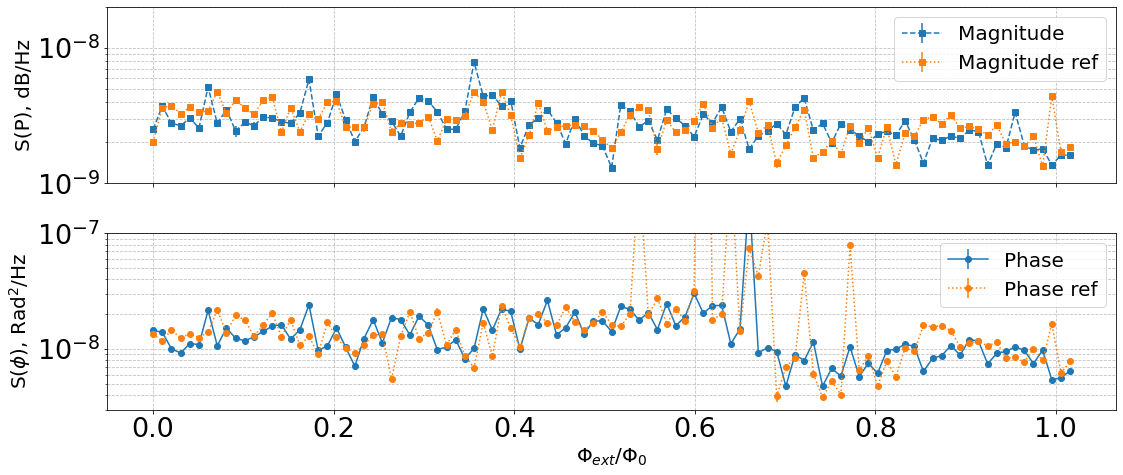

In [149]:
matplotlib.rc('font', size=20)

# Plot setup
fig, ax = plt.subplots(2, 1, figsize=(16, 7), sharex = True)
ax[1].errorbar(vna_dBm[:len(a_pha)], a_pha, yerr=a_pha_err, fmt='o-', label='Phase')
ax[0].errorbar(vna_dBm[:len(a_mag)], a_mag, yerr=a_mag_err, fmt='s--', label='Magnitude')
ax[1].errorbar(vna_dBm[:len(a_pha_ref)], a_pha_ref, yerr=a_pha_err_ref, fmt='o:', label='Phase ref')
ax[0].errorbar(vna_dBm[:len(a_mag_ref)], a_mag_ref, yerr=a_mag_err_ref, fmt='s:', label='Magnitude ref')

# Labels and scales
ax[0].set_ylabel("S(P), dB/Hz")
ax[1].set_ylabel(r"S($\phi$), Rad$^2$/Hz")
ax[1].set_xlabel(r'$\Phi_{ext}/\Phi_{0}$')

ax[0].set_yscale('log', base=10)
ax[1].set_yscale('log', base=10)

ax[0].legend()
ax[1].legend()

ax[1].set_ylim(3e-9, 1e-7)
ax[0].set_ylim(1e-9, 2e-8)


for ax in [ax[0], ax[1]]:
    ax.grid(True, which="both", ls="--", alpha=0.8)
    ax.tick_params(labelsize=27)
    
plt.tight_layout()
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\DC_stability.png", dpi=300, bbox_inches='tight')
plt.show()

# FFT test

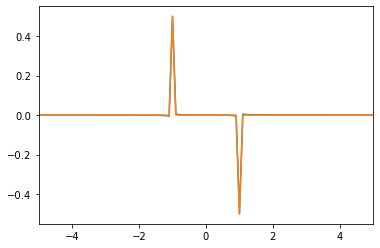

In [94]:
%matplotlib inline


fig, ax = plt.subplots()

# norm = 'backward' # wrong
norm = 'forward' # correct

N = 101
period_N = 10
test_t = np.linspace(0, period_N, N*period_N+1)
test_signal = np.sin(test_t*2*np.pi)

test_FFT = fft(test_signal, norm = norm)
test_FFT = fftshift(test_FFT)
test_freqs = np.linspace(-N/2, N/2, N*period_N+1)
ax.plot(test_freqs, np.imag(test_FFT))


N = 1001
period_N = 10
test_t = np.linspace(0, period_N, N*period_N+1)
test_signal = np.sin(test_t*2*np.pi)

test_FFT = fft(test_signal, norm = norm)
test_FFT = fftshift(test_FFT)
test_freqs = np.linspace(-N/2, N/2, N*period_N+1)
ax.plot(test_freqs, np.imag(test_FFT))


ax.set_xlim(-5,5)

plt.show();